<!--TABLE OF CONTENTS-->
# Table of Contents
  - [Intro: The MLP classifier and RAVDESS dataset](#Intro:-The-MLP-classifier-and-RAVDESS-dataset)
    - [Overview](#Overview)
  - [Feature Engineering](#Feature-Engineering)
    - [Short-Time Fourier Transform](#Short-Time-Fourier-Transform)
    - [Mel-Frequency Cepstral Coefficients](#Mel-Frequency-Cepstral-Coefficients)
    - [Mel Spectrograms and Mel-Frequency Cepstrums](#Mel-Spectrograms-and-Mel-Frequency-Cepstrums)
    - [The Chromagram](#The-Chromagram)
  - [Feature Extraction](#Feature-Extraction)
    - [Load the Dataset and Compute Features](#Load-the-Dataset-and-Compute-its-Features)
  - [The MLP Model for Classification](#The-MLP-Model-for-Classification)
    - [Training: The 80/20 Split and Validation](#Training:-The-80/20-Split-and-Validation)
    - [Choice of Hyperparameters](#Choice-of-Hyperparameters)
    - [Hyperparameter Optimization: Grid Search](#Hyperparameter-Optimization:-Grid-Search)
    - [K-Fold Cross-Validation](#K-Fold-Cross-Validation)
    - [The Validation Curve: Further Tuning of Hyperparameters](#The-Validation-Curve:-Further-Tuning-of-Hyperparameters)
    - [The Learning Curve: Determining Optimal Training Set Size](#The-Learning-Curve:-Determining-Optimal-Training-Set-Size)
  - [Alternative Models](#Alternative-Models)
      - [The Support Vector Classifier](#The-Support-Vector-Classifier)
      - [k Nearest Neighbours](#k-Nearest-Neighbours)
      - [Decision Tree Ensemble Model: Random Forest](#Decision-Tree-Ensemble-Model:-Random-Forest)
      - [Next Steps](#Next-Steps)
  - [Conclusion](#Conclusion)

## Intro: The MLP classifier and RAVDESS dataset
In this notebook we train a Multilayer Perceptron (MLP) model for classification in an attempt to classify the emotion conveyed in a speech audio snippet.
MLP classifiers are a good model to start with because they are simple, flexible, and suited when inputs are assigned a label - in our case, emotion.

I'm going to use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song dataset), created by Steven Livingstone and Frank Russo of Ryerson University. <br>
[Details of the RAVDESS dataset](https://smartlaboratory.org/ravdess/) <br>
[Download the dataset used in this notebook](https://zenodo.org/record/1188976) <br> Scroll half-way down the page and find "Audio_Speech_Actors_01-24"<br>

We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB.
Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences with
a variety of emotions and intensity. We get 1440 speech files (24 actors * 60 recordings per actor). Each audio sample has been rated  by a human 10 times for emotional quality.

### Overview
1. Feature Engineering: Choose and define the properties which our model will use to evaluate the audio files. <br>
2. Feature Extraction: Compute the features for each audio file and build a feature matrix representing all audio files. <br>
3. Train an MLP Classifier model: Choose and optimize the properties of our model - hyperparameters and architechture.  <br>
4. Evaluate our model's performance: Check our model's accuracy on test data which it has never seen in training.<br>
5. Explore options for improving our model: Is our dataset the right size? Is our model too complex or too simple? <br>

## Feature Engineering
An audio file can be represented as a time series with the dependent axis being
the amplitude of the audio waveform. The waveform of the sound file is all the information we have with which to create features to train our model.
The shape of a waveform does not carry enough discriminating information, so we need to transform the waveform into a more useable form, pun intended. <br>
Let's confirm that a waveform might not be of much use by comparing "Happy" and "Angry" of Actor 1:

In [1]:
# Get our imports out of the way
import matplotlib.pyplot as plt
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML # Center matplotlib figures
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

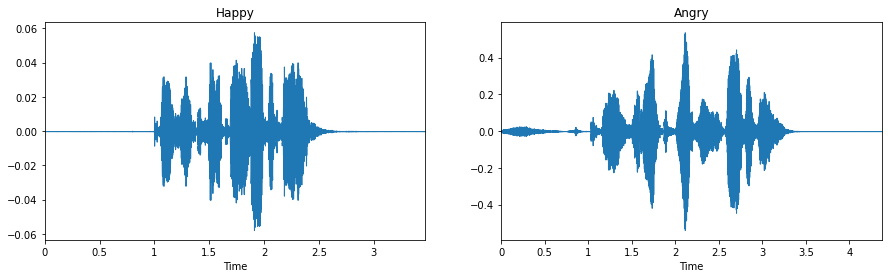

In [2]:
with soundfile.SoundFile('.\\RAVDESS dataset\\actor_01\\03-01-03-01-01-01-01.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Happy')

with soundfile.SoundFile('.\\RAVDESS dataset\\actor_01\\03-01-05-02-01-02-01.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 2, 2)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Angry')

Alright, there's a visible difference - but not enough to classify by emotion. Take my word for it. Try it if you like. However, [raw waveforms can be used](https://arxiv.org/abs/1712.00866) for certain other audio classification tasks with the right network. So, where do we get features suitable for emotion classification?
### Short-Time Fourier Transform
The lowest-hanging fruit in time series signal processing is, of course, the Fourier Transform.
Specifically, we'll use the Short-time fourier transform (STFT) which will cut our audio waveform into short, overlapping equal length segments and
take the fourier transform of each segment individually to produce multiple power spectrograms, identifying resonant frequencies present in our audio file. The major advantage of STFT is better resolution of _changes_ in the audio signal w.r.t. time. <br>
<img src="img/stft.png" width=600 height=600 />

Let's start visualizing our features to get a better handle on them. <br>
Load a sample audio file from our dataset - each audio file is 3 seconds in length.

In [3]:
with soundfile.SoundFile('.\\RAVDESS dataset\\actor_01\\03-01-03-01-01-01-01.wav') as audio:
    happy_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

with soundfile.SoundFile('.\\RAVDESS dataset\\actor_01\\03-01-05-02-01-02-01.wav') as audio:
    angry_waveform = audio.read(dtype="float32")
    # same sample rate

##### Visualize the combination of power spectrograms output by STFT w.r.t time:

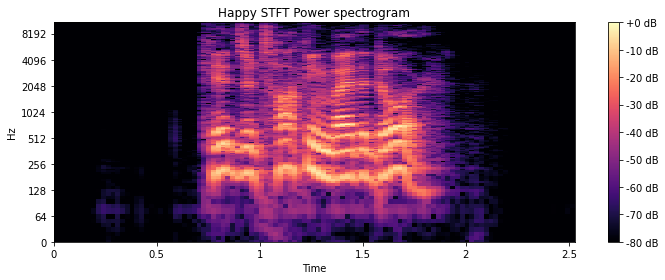

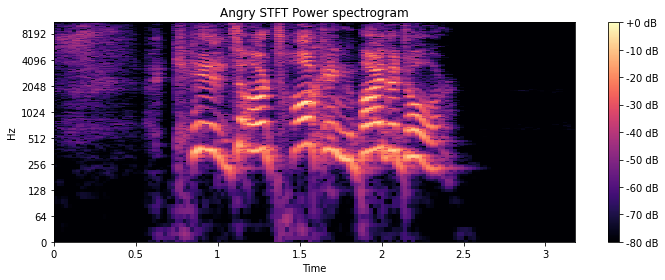

In [4]:
import numpy as np

stft_spectrum_matrix = librosa.stft(happy_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Happy STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(angry_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Now we're talking. We operate under the assumption that features whose intersample differences we can visualize will be good candidates on which to train a neural network. Looks like further transformations on the STFT will yield good features. Since we have a 3 second audio file, STFT spectrograms for these audio samples combine to show the change in frequencies across a 3 second window.

### Mel-Frequency Cepstral Coefficients
We're going to build on the STFT by using the Mel Frequency Cepstral Coefficients (MFCCs) as a feature.
In brief, MFCC is a mathematical method which transforms the power spectrum of an audio signal to a small number of coefficients representing power of the audio signal in a frequency region (a region of pitch) taken w.r.t. time. 
<br><br>
In other words, MFC coefficients give us an idea of the changing pitch of an audio signal. 

To understand our major feature a little better, we should at least have a vague idea of the math behind it.
MFCC at its core uses STFT to produce audio power spectrums. We then apply triangular, overlapping window functions to the power spectrograms and take the sum of energy in each window which is essentialy a frequency bin. To determine the number and position of window functions, and width of each frequency bin, we map the frequencies of our audio's power spectrograms to the [Mel scale](https://en.wikipedia.org/wiki/Mel_scale), a nonlinear pitch scale representing the perceived pitch in 'mels' of an audio signal w.r.t. its frequency. The motivation for the mel scale is to account for the way human hearing perceives pitch based on frequency ratios rather than absolute differences in frequencies. The window functions/frequency bins we applied in this step are called mel filterbanks.

Now we can take the log of the sum of power in each mel frequency filterbank. Taking the log power of an audio spectrogram produces a cepstrum - more on this a little later. 

###### The Discrete Cosine Transform
Finally, we apply the discrete cosine transform [(DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) to the log of power in each filterbank. The DCT carries distinguished advantages: Because triangular window functions overlap, the mel filterbank energies are correlated with each other; DCT decorellates the signals; DCT produces coefficients such that usually only the top few coefficients are necessary to represent a signal with fair accuracy, i.e. a compressed representation. **In this way, DCT is quite similar to PCA** - one key difference being that DCT has an absolute definition while PCA is only defined w.r.t. a dataset. For this reason (and a couple others) DCT sees a _huge_ range of applicability: image and audio data compression (read: internet, wireless tech, medicine) and cryptography are most notable. Our MFC coefficients are then the amplitudes of each DCT-transformed log filterbank power, taken w.r.t. time. 

Another way to think about MFCC is as a deconvolution method to identify periodic, or resonant structures within an audio signal's frequency space. We can visualize our MFC coefficients by plotting the coefficients provided by each mel filterbank against time. 

I've found for this task that 40 filterbanks producing 40 coefficients provide the best accuracy and quick computation. 

###### Visualize our sample's MFC coefficients w.r.t time:

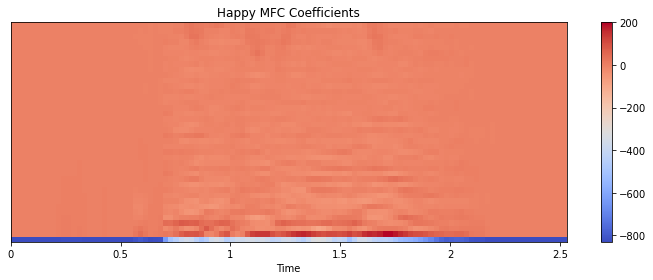

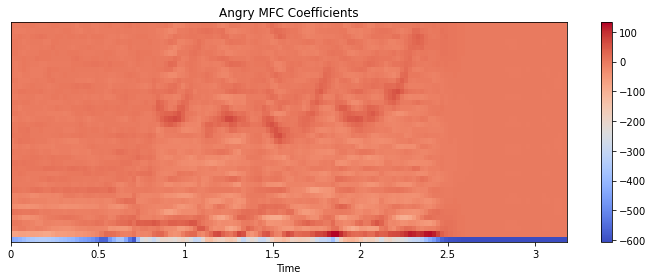

In [5]:
mfc_coefficients = librosa.feature.mfcc(y=happy_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time')
plt.colorbar()
plt.yticks
plt.title('Happy MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time')
plt.colorbar()
plt.yticks
plt.title('Angry MFC Coefficients')
plt.tight_layout()

Indeed, a visible difference. Take note also of the difference in the scales to the right of the two plots.

##### Quick MFCC Derivation
1. Take the square of magnitudes in spectrograms produced by STFT to produce audio power spectrograms for short overlapping frames of the audio signal, <br>
2. Apply a mel-scale-based transformation, mel filterbanks (triangular window functions) to each STFT power spectrogram and sum the power in each filterbank <br>
3. Take the log of each filterbank power <br>
4. Take the discrete cosine transform of each log power in each STFT frame, giving us the MFC coefficients - our measure of power at various mel frequencies, corresponding to audible pitch. <br>

Wikipedia has a pretty straight-forward explanation of [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).



### Mel Spectrograms and Mel-Frequency Cepstrums
In deriving our MFCCs, we have also produced an additional feature we can make use of. 
When we mapped the frequencies of a power spectrogram to the mel scale, we produced a Mel Frequency Spectrogram - 
a simple analog of the power spectrogram with the frequency scale in mels. 
We're going to use the Mel Specotrgrogram as a feature of its own. 

##### Visualize our sample's Mel spectrogram w.r.t time:

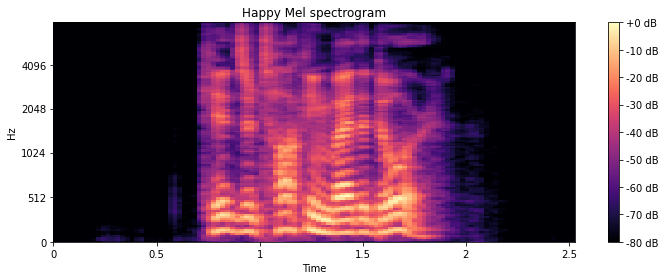

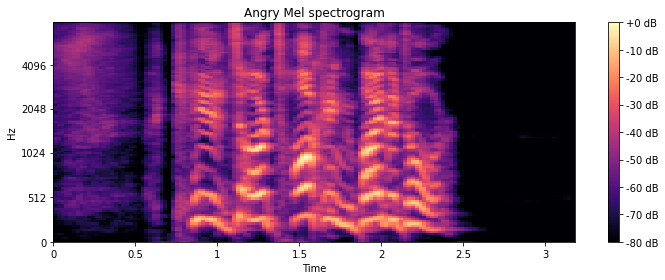

In [6]:
melspectrogram = librosa.feature.melspectrogram(y=happy_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.max),y_axis='mel',fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Happy Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=angry_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.max),y_axis='mel',fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Angry Mel spectrogram')
plt.tight_layout()

Looks like the mel spectrogram will make an excellent feature.

What about the cepstrum? When we took the log of the spectral amplitudes in a Mel-scaled power spectrogram, we could have plotted that result as a time series and produced what is known as a 'mel-frequency cepstrum', now in the 'quefrency' domain, so confusingly named because we have applied a transformation to an audio signal in its frequency domain, but have plotted it as a time series - not quite in the frequency domain, not quite in the time domain. In the cepstrum, we observe a peak wherever there is a periodic element in the original audio signal. We've actually already used the the mel-frequency cepstrum (MFC) as a feature, since that is precisely the source of our MFC coefficients. Again, Wikipedia has a fairly palatable explanation of the [cepstrum](https://en.wikipedia.org/wiki/Cepstrum). 

Below is an excellent visualization of the transformations between waveform, spectrogram, mel spectrogram, and MFCCs plotted as time series.
The vertical frame in each graph represents a single STFT frame.<br>
<img src="img/mfcc.gif" width=800 height=600/> <br>


### The Chromagram
To extract an additional feature, we're going to build a chromagram on each power spectrogram computed by STFT. A chromagram is a representation of an audio signal w.r.t. time, mapping audio signal to a pitch class.
Most often, we map to the 12 standard pitch classes (i.e. the musical scale CDEFGAB + 5 semitones gives us 12 pitch classes).
Again, wikipedia has a short and sweet [explanation](https://en.wikipedia.org/wiki/Chroma_feature). Below is a visualization of the relation between an audio waveform and its chromagram:

<img src="img/chromagram.png" width=500 height=500 />

##### Visualize the chromagram for our sample audio:

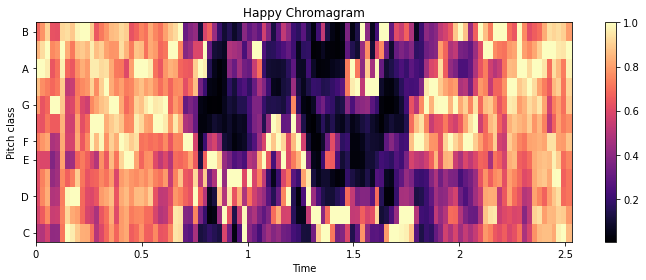

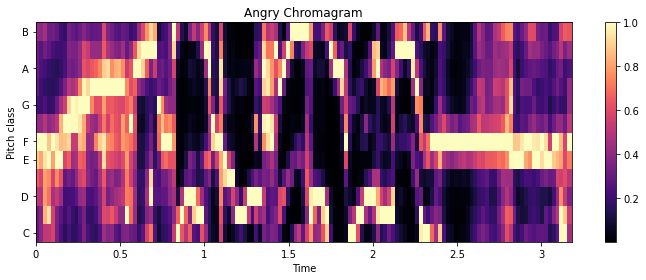

In [7]:
chromagram = librosa.feature.chroma_stft(y=happy_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Happy Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=angry_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Angry Chromagram')
plt.tight_layout()

We see the differences in the relative intensity of each pitch class in our audio files w.r.t time.

## Feature Extraction
We're going to take full advantage of librosa, a Python library enabling audio analysis and feature extraction.
Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC. 
Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try
and have bit more discriminatory power between samples. <br>

Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC**: Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40 which I found to work well

In [5]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

We're going to wrap our feature extraction functions so we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we're going to
stack them horizontally to create a single feature array.

In [6]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        
        return feature_matrix

### Load the Dataset and Compute Features
We have to understand the labelling of the RAVDESS dataset to find the ground truth emotion for each sample.
Each file is labelled with 7 numbers delimited by a "-".
Most of the numbers describe metadata about the audio samples such as their format (video and/or audio),
whether the audio is a song or statement, which of two statements is being read and by which actor.

The third and fourth numbers pertain to the emotional quality of each sample. The third number is in the range of 1-8 with each number representing an emotion.
The fourth number is either 1 or 2, representing normal (1) or strong (2) emotional intensity.

We're going to define a dictionary based on the third number (emotion) and assign an emotion to each number as specified by the RAVDESS dataset:

In [7]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

Finally, let's load our entire dataset and compute the features of each audio file:

In [8]:
import os, glob

def load_data():
    X,y=[],[]
    c,ms,mf = [],[],[]
    for file in glob.glob(".\\RAVDESS dataset\\actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

Compute the feature matrix and read the emotion labels for the entire dataset.
Note that our regressor (independent/explanatory variable), usually denoted X, is named 'features', and our regressand (dependent variable), usually denoted y, is named 'emotions'.

In [9]:
features, emotions = load_data()

Let's see what the features we extracted look like:

In [12]:
import pandas as pd
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
features_df


Audio samples represented: 1440
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.633752,0.648747,0.621731,0.634556,0.660326,0.660486,0.700930,0.731556,0.746887,0.723435,...,-3.130589,-2.700900,-1.888213,-0.554155,-3.964599,-2.134852,-3.945771,-1.624579,-2.039907,-3.629109
1,0.660875,0.705912,0.703556,0.672467,0.693959,0.728635,0.716797,0.758791,0.785981,0.786871,...,-3.480977,-2.376257,-0.995905,-1.865461,-4.270066,-2.396406,-4.606637,-1.184742,-2.140252,-2.958484
2,0.716729,0.705105,0.707905,0.727850,0.695296,0.698327,0.743120,0.790097,0.815669,0.742015,...,-2.590883,-2.652148,-1.988785,-1.423693,-4.326625,-2.718752,-3.028184,-1.541225,-2.313979,-2.466609
3,0.725767,0.712236,0.700385,0.719994,0.744948,0.750953,0.744565,0.791981,0.806350,0.761700,...,-3.747972,-2.862656,-1.471904,-1.322888,-3.609182,-3.812896,-3.526280,-1.526215,-2.215406,-2.694729
4,0.603845,0.626068,0.696292,0.688255,0.679438,0.692962,0.699785,0.720104,0.734387,0.747514,...,-3.700608,-0.653383,-1.610423,-1.536218,-3.604611,-3.623069,-4.170883,-2.334510,-1.299900,-1.498901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.598480,0.521324,0.491678,0.529918,0.559808,0.571009,0.620753,0.623964,0.632223,0.627766,...,-0.329260,-1.489990,-2.404569,-1.168336,-1.356913,0.069666,-1.538895,-1.436664,-1.054515,-1.361095
1436,0.668894,0.686021,0.639824,0.610624,0.594836,0.562757,0.561363,0.609690,0.617460,0.612550,...,-1.158591,0.621641,-0.323034,-1.766248,-1.689050,-0.417855,-1.783543,-0.085183,-0.000292,-0.175321
1437,0.632550,0.612255,0.547708,0.537014,0.537187,0.581168,0.586129,0.561292,0.579341,0.593762,...,-1.348669,0.198006,-0.209769,-0.897088,-1.195494,-0.304176,-1.501332,-0.832731,-1.616237,-1.657163
1438,0.574530,0.544936,0.543283,0.532215,0.539510,0.599558,0.623495,0.597271,0.567244,0.591442,...,-1.365634,0.276205,0.135981,1.369041,-0.963551,0.436777,0.991504,-0.205438,-0.684227,-0.685091


We have a matrix of dim 1440 x 180. Looks good - 1440 audio samples, one per row, with a series of
180 numerical features for each sample. 

**Each 180-long feature array is composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFCC coefficients.**



## The MLP Model for Classification
We're going to first try a Multilayer Perceptron (MLP) Classifier, a simple artificial neural network (ANN) model well-suited for predictions trained on labelled inputs. We're going to skip classic off-the-shelf classifiers like support vector machines (SVM) and Random Forests An MLP network consists of an input layer, _n_ hidden layers, and an output layer. The logic of the network depends on its weights: An array [w<sub>0</sub>-w<sub>i</sub>] for _each node_ in all layers, one weight value for each node-node connection (edge) in the graph representation (a matrix _W_ for the network). We also have biases, an array [b<sub>0</sub>-b<sub>j</sub>] for _each layer_, one value for each node (a matrix _B_ for the network). I'll speak more to its architechture below.

<img src="img/mlp.png" width=500 height=500 />

### Training: The 80/20 Split and Validation
We'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of
the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

More accurately, the proper modality for training and scoring a model is to 
1. Fit/train our model on a _training_ set, 
2. Evaluate the model on a _validation_ set to tune the hyperparameters for better performance,
3. Finally score our model's true performance - its **generalizability** - against a _test_ set, aka the hold-out set. 
4. Repeat from 2. **Do not tune the model to score well on the test set**. 

Different set ratios are used in this approach - a usual example is 60/20/20 train/validation/test. 

For simplicity, we're going to start with an 80/20 train/test split. The model will be trained on all the training data, and we will check its performance on the test data. We initialize an MLP classification model and try the default settings for the model as determined by sklearn. 

Using default settings for neural networks is not a good idea in general - and checking a model's performance on test data before tuning the model on a validation set is **incorrect methodology**... but for demonstrative purposes:

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

model = MLPClassifier(
    random_state = 69
)

# Split our feature matrix into 80/20 training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    emotions, 
    test_size=0.2, 
    random_state=69
)
model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Possible emotions predicted by model:['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
MLP Model's accuracy on training set is 61.81%
MLP Model's accuracy on test set is 46.18%


Great - we expected terrible performance with no thought given to the model. Otherwise, what would a machine learning engineer do? At any rate, we at least know that our model's possible predictions - classes - are correct, and it's even doing a little better than guessing with a 1/8 (12.5%) chance. More than we can ask for with this approach.

Perhaps with some work we can make the MLP model work for us.

### Feature Scaling
To properly train an MLP model, we first need to scale our features. If there is a difference in the variance of features simply because of their possible range of values, then the MLP - and many others, such as those mentioned near the end of this notebook - these models will learn that the features with the greatest variance are the most important. However, **variance in unscaled features belonging to different distributions is an inappropriate measure of importance.** Let's check our features' properties:

In [13]:
# Check chromagram feature values
features_df_chromagram = features_df.loc[:,:11]
chroma_min = features_df_chromagram.min().min()
chroma_max = features_df_chromagram.max().max()
chroma_mean = features_df_chromagram.mean().mean()
chroma_stdev = features_df_chromagram.std().std()
print(f'12 Chromagram features:       \
min = {chroma_min:.3f}, \
max = {chroma_max:.3f}, \
mean = {chroma_mean:.3f}, \
deviation = {chroma_stdev:.3f}') 

# Check mel spectrogram feature values
features_df_melspectrogram = features_df.loc[:,12:139]
mel_min = features_df_melspectrogram.min().min()
mel_max = features_df_melspectrogram.max().max()
mel_mean = features_df_melspectrogram.mean().mean()
mel_stdev = features_df_melspectrogram.std().std()
print(f'\n128 Mel Spectrogram features: \
min = {mel_min:.3f}, \
max = {mel_max:.3f}, \
mean = {mel_mean:.3f}, \
deviation = {mel_stdev:.3f}')

# Check MFCC feature values
features_df_mfcc = features_df.loc[:,140:179]
mfcc_min = features_df_mfcc.min().min()
mfcc_max = features_df_mfcc.max().max()
mfcc_mean = features_df_mfcc.mean().mean()
mfcc_stdev = features_df_mfcc.std().std()
print(f'\n40 MFCC features:             \
min = {mfcc_min:.3f}, \
max = {mfcc_max:.3f}, \
mean = {mfcc_mean:.3f}, \
deviation = {mfcc_stdev:.3f}')

12 Chromagram features:       min = 0.253, max = 0.898, mean = 0.637, deviation = 0.004

128 Mel Spectrogram features: min = 0.000, max = 172.281, mean = 0.186, deviation = 1.364

40 MFCC features:             min = -839.964, max = 92.224, mean = -14.229, deviation = 15.516


There's an obvious **imbalance in the variance our features**. Our features indeed belong to very different distributions: our MFC coefficients' deviation is greater than the other features by orders of magnitude. That does not mean MFC coefficients are the most important feature, but rather it is a property of the way they are computed.  We will certainly need to scale this feature set.

We have the choice of sklearn's StandardScaler and MinMaxScaler. Standard scaling subtracts the mean of each feature and divides it by the standard deviation of that feature, producing features with mean at zero and unit variance - that is, a variance and standard deviation of 1. Min-Max scaling transforms each feature to be within a bounded interval that we specify. 

In practice, **MinMax scaling is especially useful when we know our features should be in a bounded interval**, such as pixel values in [0,255], while **standard scaling is perhaps more practical for features with varying distributions** because centering the features at zero-mean with a standard deviation of 1 means extreme values will have less of an impact on the model's learned weights, i.e. the model is less sensitive to outliers. 

We'll give MinMax scaling a go as well to confirm that standard scaling is better in the absence of knowledge on the appropriate distribution for a dataset's features ... and because our MLP model takes about 3 seconds to train at this stage.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features 
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

In [ ]:
# Create DataFrame of scaled features for easy slicing and analysis
features_df_scaled = pd.DataFrame(features_scaled)

# Check chromagram feature values
features_df_chromagram = features_df_scaled.loc[:,:11]
chroma_min = features_df_chromagram.min().min()
chroma_max = features_df_chromagram.max().max()
chroma_mean = features_df_chromagram.mean().mean()
chroma_stdev = features_df_chromagram.std().std()
print(f'12 Chromagram features:       \
min = {chroma_min:.2f}, \
max = {chroma_max:.2f}, \
mean = {chroma_mean:.2f}, \
deviation = {chroma_stdev:.2f}') 

# Check mel spectrogram feature values
features_df_melspectrogram = features_df_scaled.loc[:,12:139]
mel_min = features_df_melspectrogram.min().min()
mel_max = features_df_melspectrogram.max().max()
mel_mean = features_df_melspectrogram.mean().mean()
mel_stdev = features_df_melspectrogram.std().std()
print(f'\n128 Mel Spectrogram features: \
min = {mel_min:.2f}, \
max = {mel_max:.2f}, \
mean = {mel_mean:.2f}, \
deviation = {mel_stdev:.2f}')

# Check MFCC feature values
features_df_mfcc = features_df_scaled.loc[:,140:179]
mfcc_min = features_df_mfcc.min().min()
mfcc_max = features_df_mfcc.max().max()
mfcc_mean = features_df_mfcc.mean().mean()
mfcc_stdev = features_df_mfcc.std().std()
print(f'\n40 MFCC features:             \
min = {mfcc_min:.2f}, \
max = {mfcc_max:.2f}, \
mean = {mfcc_mean:.2f}, \
deviation = {mfcc_stdev:.2f}')

Now let's check what kind of performance gain we get:

In [50]:
# Define model again
model = MLPClassifier(
    random_state = 69
)

#################### standard scaler #######################
# Rebuild the training set from the standard scaled features
# The labels (y_train, y_test) don't change, keep old values 
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)
# Fit the model again on the scaled features
model.fit(X_train_scaled, y_train)

print(f'Standard scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Standard scaled MLP Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%\n')

#################### minmax scaler #######################
# Rebuild the training set from the minmax scaled features
# The labels (y_train, y_test) don't change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

# Fit the model again on the scaled features
model.fit(X_train_minmax, y_train)

print(f'MinMax scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'MinMax sacled MLP Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%')

Standard scaled MLP Model's accuracy on training set is 99.91%
Standard scaled MLP Model's accuracy on test set is 64.24%

MinMax scaled MLP Model's accuracy on training set is 66.75%
MinMax sacled MLP Model's accuracy on test set is 52.78%


That's more like it. Standard scaling is indeed the way to go here. Ok, now let's try and give our MLP model a fighting chance by actually paying attention to what it's doing.


### Choice of Hyperparameters
Before training a network we must select hyperparameters, which determine the network's learning behaviour - hyperparameters determine how the network learns its weights and biases, while the network parameters determine what those weights and biases are. Each type of model (SVC, MLP, Random Forests, etc...) come with their own set of hyperparameters, and each type of optimization algorithm does as well. We may use the same optimization algorithm for two different models, but memorizing the best hyperparameters for one model won't help us with any other model and likely, not any other task even with the same model.

The MLP model has a number of hyperparameters significant to its learning behaviour: 
- **Alpha**: Constrains the model's weights to be within a certain bound to address overfitting; in range [0,1], parameterizes l2 penalty which defines how steeply the cost function modifies weights in proportion to their magnitude, i.e. **regularizes** the cost function and so is also called the regularization term. In practice, **higher alpha more steeply penalizes large weights.**
- **Activation function:** Determines the output of a neuron by the transformation applied to the set of inputs to that neuron
- **Solver:** Algorithm(s) used for optimization of our weights (with backpropogation **gradient descent** in the case of the MLP classifier)
- **Learning rate:** How large of a change the optimization algorithm makes to the model's weights at each training iteration
- **Epsilon:** Unique to the 'adam' solver, numerical stability - to avoid divison by zero. 

#### Network Architecture
The input layer of our MLP neural network is the size of our feature space - that is, one neuron per feature. In our case, 180 input neurons constitute the input layer. Since we are performing multiclass classification, our MLP network has one neuron in its output layer for each class label. In our case 8 output neurons, one per emotion. 

The size of our hidden layer is of interest and a more dubious task than choosing other hyperparameters, because the behaviour of different numbers and sizes of hidden layers is much less transparent. There are many opinions on the matter, but there is relative consensus in that **many tasks rarely benefit from more than one hidden layer**, i.e. one hidden layer is sufficient in most cases. The number of neurons in that hidden layer is a less obvious choice, but it seems from literature that a number between the input layer and output layer size is a good starting point. At any rate, the time complexity of training our model scales exponentially with the number of hidden layers, so let's keep that number at the minimum, and likely optimum of 1. See "How many hidden layers/units should I use?" from [this comprehensive FAQ](http://www.faqs.org/faqs/ai-faq/neural-nets/part1/preamble.html). 

### Hyperparameter Optimization: Grid Search
We're going to take advantage of the grid search cross-validation algorithm to find the best hyperparameters for us.

Grid search is relatively simple to understand - we specify a set of candidate values for each hyperparameter, and grid search tries all combinations of those hyperparameter values to build and score potential models against our training and validation data. Grid search scores sets of hyperparameters by building a validation set from the training set we give it.

We initialize the MLP classifier with the hyperparameters we will keep constant, those less likely to have a significant impact on the model's performance. We shouldn't use grid search to look for hyperparameters we can easily tune later, such as the number of training iterations (# of forward+backward passes through the network for each _batch_ of training samples); if we do so, we significantly inflate the computational cost with little return. For these hyperparameters we should choose values which are usually reasonable from a literature search (...from stackexchange). 

In case grid search is too expensive for the hyperparameter grid we specify, **Randomized Grid Search** can be used to sample a fixed number of hyperparameter combinations from the distribution of settings we define.

We define a random state so that we can accurately compare any improvements we make to the model. 

We also define a **batch size**: the number of training samples included in one forward (input) and backward (error) pass of the model, which is one **iteration**. A batch size in range [1, #samples] is common - in our case, [1,1440\*0.8]. [**Mini-batches**](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) in the set [32, 64, 128, 256] are usually encouraged, especially on smaller datasets. **Smaller batches** cause more frequent weight updates and faster convergence - faster learning - though each update is less accurate compared to a larger batch. **Larger batches** train on a larger set of inputs simultaneously, and so may optimize loss better at each iteration due to a more accurate gradient computation - however, large batches may encourage overfitting and worsen generalization error.

In [53]:
from sklearn.model_selection import GridSearchCV

# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later 
    batch_size=256,  
    # keep random state constant to accurately compare subsequent models
    random_state=69
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(8,), (180,), (300,),(100,50,),(10,10,10)], 
    'activation': ['tanh','relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [1e-08, 0.1 ],
    'learning_rate': ['adaptive', 'constant']
}
   
# Create a grid search object which will store the scores and hyperparameters of all candidate models 
grid = GridSearchCV(
    model, 
    parameter_space,
    cv=10,
    n_jobs=4)
# Fit the models specified by the parameter grid 
grid.fit(X_train, y_train)

# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

Best parameters found:
 {'activation': 'logistic', 'alpha': 0.01, 'epsilon': 1e-08, 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'solver': 'adam'}


Grid search chose the logistic sigmoid function as the best activation function, suited to binary classification. However, our labels belong to >2 classes and so while our **hidden layer use the logistic function** for its activation on each neuron, our **output layer will necessarily use the softmax function** - an exponential normalization function - in order to scale output neuron values to a probability between \[0,1\] for each class (emotion). Softmax does this normalization by taking the exponent of the value of each output neuron and dividing that by sum of the exponentiated output values, producing _n_ probabilities for _n_ classes. We then choose the highest probability as the predicted class for a set of input features. To be clear, **softmax activation is applied to the values of _all_ output neurons _once_ - not to each neuron.**    

The solver chosen is the **Adam optimization** algorithm, a variant of **stochastic gradient descent** (SGD). Unlike SGD, which maintains a constant learning rate throughout each training iteration, Adam actually 'adapts', or varies the learning rate by taking into account the moving averages of the first and second moments (mean and variance) of the gradient at each training iteration. It makes sense that grid search chose the more sophisticated algorithm - note however it's not necessarily better than SGD for all tasks.  

The values for **alpha** and **epsilon** are what we usually find standard in many other classification tasks using the Adam optimization algorithm; alpha=0.001 and epsilon=1e-8 are the gold-standard defaults proposed by the **[Adam paper](https://arxiv.org/abs/1412.6980)** - an excellent and easily digestable read. We'll also have to specify beta_1 and beta_2 for Adam, which are the decay constants for the moving averages of the first and second moments of the gradient. We'll take the standard values of beta_1=0.9, beta_2=0.999 as also proposed by the aforementioned paper.

As expected, the ideal architechture involves just one hidden layer - though with double the neurons we expected for 180 features. Training the 2 and 3 hidden layer models was extremely computationally expensive compared to 1 hidden layer - and provided absolutely no benefit, only complexity and wasted resources. A good reinforcement of the power of simplicity, especially in deep neural networks. In the domain of model simplicity, there is also a compelling argument to be made for interpretability (to the point a model should _never_ be a black box) ...but that's for another time.

We can now initialize our MLP model with the best hyperparameters for the task of speech emotion classification.

In [54]:
# declare again so I don't have to re-run gridsearch when I restart the jupyter kernel
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

model = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    alpha=0.01, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=1e-08, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive',
    max_iter=500, # I've found for this task, loss converges at 500 iterations
    random_state=69,
)

model.fit(X_train, y_train)

print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

MLP Model's accuracy on training set is 99.31%
MLP Model's accuracy on test set is 62.50%


That's a lot better - but not great. At any rate, our MLP model is **overfitting the training data and not generalizing well to the test set**. With the near-perfect training accuracy it's clear our model's loss function is converging - let's see:

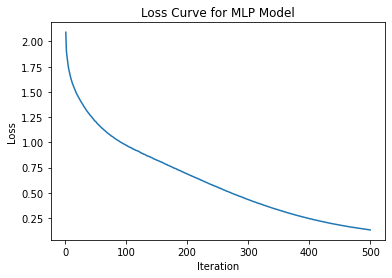

In [55]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

It is indeed converging. Because of its perfect performance on the training data and poor performance on test data, we at this point suspect our model has too high a variance: It's learning to fit its weights so precisely to the training data to score well on it that its performance doesn't extend past that training data. If we had seen poor performance on both training and test sets, we would suspect our model to have a high bias. 

To solve **high variance**, wherein our model is overfitting to noise present in the training data, we can **decrease the number of input features and/or increase the size of the training set** so our model has more data to learn on and can generalize better to data it has not seen. 

In contrast, to solve **high bias**, wherein our model is underfitting to the data, we could **increase the number of input features** so that it can learn a better fit to the underlying data.

**High variance makes the model's predictions inconsistent**, while **high bias makes them inaccurate** and vice versa, respectively. Ultimately, we aim to make a model that is both accurate and consistent: low variance and low bias with good performance. There is almost always a trade-off between the two.

### K-Fold Cross-Validation
To highlight the importance of proper model validation and get a better idea of our model's performance,
we're going to use K-Fold Cross-Validation (K-Fold CV). We split our training dataset into _K_ unique validation sets (_K_ sets/folds) - the train/validation split being determined by _K_ where each _validation set = (100/K)%_ of the entire dataset, the training set being composed of the remaining _K-1_ validation sets. The term cross-validation refers to validating the model on multiple validation sets.

The terminology here may be somewhat confusing, because we usually **split our 80% _training_ set into a _training_ and _validation_ set at each iteration of K-Fold CV.** We reserve the actual _test_ set - the one we made originally with an 80/20 split of the entire dataset - for checking our model's performance _after_ we have tuned its hyperparameters.

In this way, K-Fold CV will train and score _K_ different versions of our classifier.
Note that while training sets overlap (unless otherwise defined, e.g. sklearn's GroupKFold), validation sets never overlap.
We'll use 10-fold CV, with _K=10_ being a choice giving average scores of models with fairly low bias and moderate variance due in part to the resulting 90/10 train/validation ratio. 

**K-Fold CV trains our model on _K=10_ different, overlapping training folds and check its performance against _K=10_ validation folds.**

Smaller datasets would theoretically be better scored with **higher _K_,** meaning we will have a larger portion of our dataset in training sets and a greater overlap of training samples between folds - this way we better represent a small dataset, have more training data, and hopefully provide a **better estimate of the model's true generalization error**, though at the cost of **higher variance because the _K_ estimates of our model's performance are correlated** (though there are exceptions). In the extreme case, and for computationally inexpensive models, **leave-one-out K-Fold CV (LOOCV)** can be used to construct training folds consisting of all samples-1, and 1 sample with in the validation fold; _each training fold differs by just 1 sample_ and this method provides adequate training data for each model validation on smaller training datasets. 

Sine we're training a classifier, we use **StratifiedKFold which preserves the percentage of samples in each class** (emotion) for each fold. Although we have a balanced dataset, Stratified K-Fold CV is especially important when classifying an imbalanced dataset. We also set shuffle=True to shuffle the order of sample classes in each fold to match the default behaviour of sklearn's train_test_split so we can accurately compare that to the K-Fold CV score.

Choose _K_ for our K-Fold CV and train the MLP classifier on each set of train/validation folds:

In [20]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10, 
    random_state=69, 
    shuffle=True
)

scores = []
for train_indices, test_indices in kfold.split(X_train, y_train):
    # fit model to training fold
    model.fit(X_train[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train[test_indices], y_train[test_indices]))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for MLP:
54.31%
57.76%
56.52%
66.09%
62.61%
52.17%
57.39%
60.00%
61.74%
63.48%
Mean score of KFold CV for MLP: 59.21% ± 4.13%


Indeed, a bit worse, but a more accurate evaluation of this model. When we get considerably worse performance fitting our model on random subsets of our training data, we could surmise that our model's performance is inflated by overfitting when we train and test it just once on a regular 80/20 split.

Although K-Fold CV is computationally expensive, we're getting a lot more insight out of our data and that's a serious advantage when we have very few training samples. Tuning a model to just one validation set, such as in a 60/20/20 split may 

Let's dig a little deeper.

### The Validation Curve: Further Tuning of Hyperparameters

With a validation curve, we can further check our model for overfitting dependedent on hyperparameters, and which value of what hyperparameter may be contributing to overfitting by specifying a **range of parameters against which the validation curve will cross-validate the model.** We are looking to see if our model is overfitting (high variance) or underfitting (high bias) - or whether we have achieved a suitable trade-off between variance and bias. Again, our model is overfitting because of its excellent training performance and poor performance in cross-validation. **Increasing the regularization parameter alpha encourages the weights of the MLP to be smaller and reduces our model's ability to overfit its weights to the training data,** so we'll see if we can make progress there. We're going to construct two validation curves to check whether the hyperparameters alpha (L2 penalty) or epsilon (numerical stability in adam) could be better. 

The validation curve is sort of a **grid search with one parameter**, and so we don't expect that we can tune our hyperparameters any better based on what it tells us. We could have actually told grid search to return _both_ its CV and training scores and plotted them from there to understand how each hyperparameter influences our model's predictions - but computing training score for the grid is pretty computationally expensive and not really necessary.

Sklearn's validation curve implements Stratified K-Fold CV to score the model for multiclass problems, so we'll specify _K_ = 10. 

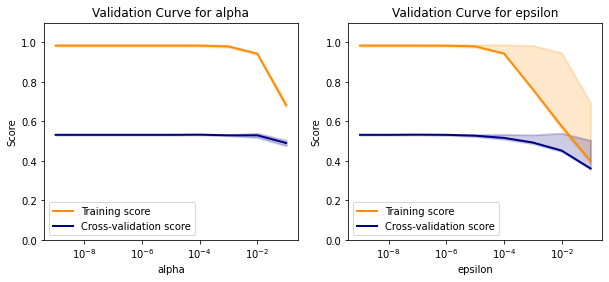

In [49]:
## import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Build validation curve for 'alpha' hyperparameter
param_range = np.logspace(-8, 0, 9) # should encompass relevant values for alpha
train_scores, test_scores = validation_curve(
    model,
    X=X_train, 
    y=y_train, 
    param_name="alpha", 
    param_range=param_range,
    scoring="accuracy",
    cv=10,
    n_jobs=4
)
# Get errors for alpha validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
param_range = np.logspace(-9, -1, 9)
# Build validation curve for 'epsilon' hypermarameter
train_scores2, test_scores2 = validation_curve(
    model,
    X=X_train, 
    y=y_train, 
    param_name="epsilon", 
    param_range=param_range,
    scoring="accuracy",
    cv=10,
    n_jobs=4
)
# Get errors for epsilon validation curve
train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

# Plot validation curve for alpha
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Validation Curve for alpha")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
linewidth = 2
# Plot alpha train scores
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=linewidth)
# Plot error window for alpha train scores
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=linewidth)
# Plot alpha test scores
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=linewidth)
# Plot error window for alpha test scores
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=linewidth)
plt.legend(loc="best")

# Plot validation curve for epsilon
plt.subplot(1,2,2)
plt.subplots_adjust(hspace=0.5)
plt.title("Validation Curve for epsilon")
plt.xlabel("epsilon")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
# Plot epsilon train scores
plt.semilogx(param_range, train_scores_mean2, label="Training score",
             color="darkorange", lw=linewidth)
# Plot error window for epsilon train scores
plt.fill_between(param_range, train_scores_mean2 - train_scores_std2,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=linewidth)
# Plot epsilon test scores
plt.semilogx(param_range, test_scores_mean2, label="Cross-validation score",
             color="navy", lw=linewidth)
# Plot error window for epsilon test scores
plt.fill_between(param_range, test_scores_mean2 - test_scores_std2,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=linewidth)
plt.legend(loc="best")
plt.show()

Nope - as expected, little to learn here because Grid Search did well for us. Our hyperparameters are just fine where they are and in fact don't make much of a difference within a reasonable range. However, the large **gap between the training score and CV score is a clear visualization of the high variance of this model**. If the validation curve was more telling we would be looking out for where the training and CV score curves are closest.

Since deep learning methods notoriously work better with large datasets, let's check if the size of our dataset might be the problem.

### The Learning Curve: Determining Optimal Training Set Size

We can use a learning curve to compare the performance of our model if we had trained it on smaller subsets of our training dataset, and thus get an idea of whether we might expect a performance increase by using more training data, or much less likely that we don't need as much data. 

We specify variable sizes of training sets to use for the learning curve to make one model for each size. Remember that since we're using 0.8\*1440 = 1152 samples in our training set, that is the upper bound that the learning curve can check for us. Like the validation curve, sklearn's learning curve implements Stratified K-Fold CV to evaluate multiclass classification models, so again we specify _K = 10_.


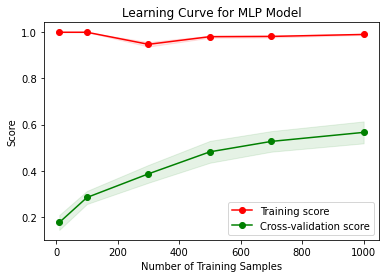

In [56]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, 
    X=X_train, 
    y=y_train, 
    cv=10, 
    shuffle=True,
    random_state=69,
    n_jobs=4, 
    # We have 0.8*1440 = 1150 samples 
    train_sizes=[10,100,300,500,700, 1000]
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

One thing the learning curve tells us that the size of the dataset isn't our biggest issue - our **accuracy is plateauing and wouldn't seriously benefit from a larger training set** - maybe 5% at most with a gigantic dataset. Again, the gap between the training score curve and cross-validation score curve shows us that the model has an extremely high variance and - it scores perfectly on training data but poorly in cross-validation because it is seriously overfit - the model does not generalize well at all on test data. 

It has become clear that an MLP network may not be the best choice of model for this task - it seems to not have the complexity we would need to properly discriminate the differences between our features w.r.t. emotion. It appears at this point that we would need a considerably more sophisticated deep neural net to get better performance on this dataset.

## Alternative Models

It's always a good idea to take 10 minutes to check if a simpler model makes sense for a particular data set **before jumping to DNNs.** In this case I went in reverse because a 1-hidden-layer MLP is pretty quick to train and an excellent (human) learning example - the MLP model in this notebook is meant simply as a route towards truly state-of-the-art networks for speech classification. 

Anyway: **Slightly degraded performance from a simple model may actually be preferable** since the time to fit something like a support vector machine (SVM) is limited by its quadratic complexity w.r.t. # of samples, while fitting an MLP classifier has a significantly higher time complexity; while it is linear w.r.t. samples, it is limited by its exponential time complexity w.r.t. number of hidden layers due to its use of backpropogation - though in the case of 1 hidden layer, the MLP competes with some classic models for time complexity. Besides, a decent argument can be made to use a classic machine learning method due to the small size of our dataset; Support vector (machine) classifiers **(SVC)** and k-Nearest-Neighbour classifiers **(kNN)** are particularly suited to smaller datasets and fall apart with huge datasets. 
### The Support Vector Classifier
 
Let's give the SVC a quick test - a model quick to train for this task and best suited to small datasets due to its quadratic time complexity w.r.t. size of the training dataset (# of training samples). 

We'll use grid search to find a good SVC candidate for fairness of comparison. We expect a non-linear kernel to be chosen since the features we have chosen are not linearly-separable.

In [57]:
from sklearn.svm import SVC

model = SVC( 
    random_state=69
)
# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate SVC models
parameter_space = {
    # linear kernel is going to give very poor performance as the features we have chosen
    # are not at all linearly separable; grid search will certainly pick a non-linear kernel
    'kernel':['linear','poly', 'rbf','sigmoid'],
    'gamma': ['scale','auto'],
    'C': [1, 10]
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models 
grid = GridSearchCV(
    model, 
    parameter_space,
    cv=10,
    n_jobs=4)
# Fit the models specified by the parameter grid 
grid.fit(X_train, y_train)

print('Best parameters found:\n', grid.best_params_)

Best parameters found:
 {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


The non-linear RBF kernel is best, and unsurprisingly since the RBF kernel usually provides a higher accuracy compared to other non-linear kernels, though at a higher computational cost.

In [58]:
model = SVC(
    C=1,
    gamma='auto',
    kernel='poly',
    random_state=69
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

scores = []
for train_indices, test_indices in kfold.split(X_train, y_train):
    # fit model to training fold
    model.fit(X_train[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train[test_indices], y_train[test_indices]))
print('KFold CV scores for SVC:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for SVC: {100*np.mean(scores):.2f}% ±{100*np.std(scores):.2f}%')

SVC Model's accuracy on training set is 30.30%
SVC Model's accuracy on test set is 25.35%
KFold CV scores for SVC:
25.00%
30.17%
20.00%
26.96%
26.09%
24.35%
20.87%
18.26%
26.09%
23.48%
Mean score of KFold CV for SVC: 24.13% ±3.40%


Quite bad, even for the relatively simple SVC model. If we had gotten an accuracy from SVC closer to the MLP classifier we might have done well to optimize the SVC model further. As it stands, nowhere near good enough to replace the MLP classifier we defined earlier.

### k Nearest Neighbours 

k Nearest Neighbours (kNN) is a tried-and-true machine learning method from the 70s. kNN makes a lot of intuitive sense: imagine plotting points on a graph and drawing gates around points that look like they belong to the same group. That's what it is - we plot our training samples' features and compare a test sample's features' distance to all those points; then just take the _k_ closest points to the test sample and pick the most frequent label/class. That's it.

kNN is a great starting point for multiclass problems with small datasets, although on large dadtasets less reliable and extremely memory hungry (it stores all training sample points). kNN is also useful in that it makes **no assumptions about the underlying distribution of the data set - so kNNs work well for both linear and non-linear data.**

Jump straight to grid search, especially because kNN will take no time to train on this dataset:

In [59]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(
    # No Random State is used in kNN 
    n_jobs=4
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate kNN models
parameter_space = {
    # linear kernel is going to give very poor performance as the features we have chosen
    # are not at all linearly separable; grid search will certainly pick a non-linear kernel
    'n_neighbors':[5,10,25,50,75,100],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'leaf_size':['30','60','90']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models 
grid = GridSearchCV(
    model, 
    parameter_space, 
    cv=10,
    n_jobs=4
)
# Fit the models specified by the parameter grid 
grid.fit(X_train, y_train)

print('Best parameters found:\n', grid.best_params_)

Best parameters found:
 {'algorithm': 'brute', 'leaf_size': '30', 'n_neighbors': 5, 'weights': 'distance'}


Sounds good. The above grid search completes in 3 seconds on my very modest machine - a nod to the merit of kNN.

In [60]:
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    leaf_size = '30',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')\

scores = []
for train_indices, test_indices in kfold.split(X_train, y_train):
    # fit model to training fold
    model.fit(X_train[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train[test_indices], y_train[test_indices]))

print('KFold CV scores for k Nearest Neighbours:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for k Nearest Neighbours: {100*np.mean(scores):.2f}% ±{100*np.std(scores):.2f}%')

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 52.08%
KFold CV scores for k Nearest Neighbours:
59.48%
57.76%
52.17%
53.04%
51.30%
52.17%
57.39%
56.52%
46.96%
49.57%
Mean score of KFold CV for k Nearest Neighbours: 53.64% ±3.81%


Not bad for 2 minutes of work, but still not suitable for this task.

### Decision Tree Ensemble Model: Random Forest 
Finally, and before resorting to sophisticated deep learning methods, let's try a Random Forest. We train many different decision trees which are essentially **directed acyclic graphs** (DAGs), somewhat similar to a flow chart. The collection of (decision) trees makes up our Random Forest. 

At each node of the tree we have a function (a rule) that evaluates whether the features of samples input to that node belong to one class or another. Each branch of the tree (or, edge of the graph) defines one of two possible results from a node, and each leaf is one of two decisions made by its parent node. Each tree in the forest evaluates a random subset of the training samples' features and has a rule at each level of the tree that classifies based on these random features - hence, _Random_ Forest. **This random selection of features makes Random Forests robust to outliers**, as such features will have less of an impact in the scope of the entire forest, most of whose trees operate on the "real" features.

Random Forests are excellent models to use as a benchmark due to their low time complexity to train and again, because it is an ensemble method, their robustness to different distributions and outliers in the dataset means Random Forests require relatively little exploratory analysis in both the data and training the model to get an idea of their performance in a task. 

In [61]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier( 
    # Use defaults for all hyperparams
    random_state=69
)

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')\

scores = []
for train_indices, test_indices in kfold.split(X_train, y_train):
    # fit model to training fold
    model.fit(X_train[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train[test_indices], y_train[test_indices]))

print('KFold CV scores for Random Forest:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for Random Forest: {100*np.mean(scores):.2f}% ±{100*np.std(scores):.2f}%')

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 53.47%
KFold CV scores for Random Forest:
57.76%
53.45%
47.83%
53.91%
58.26%
51.30%
48.70%
46.96%
58.26%
52.17%
Mean score of KFold CV for Random Forest: 52.86% ±4.05%


Not bad for zero effort! **Random Forests make a good benchmark model**, especially when strapped for time. For comparison, SVC with default hyperparameters spits out a measly 30% accuracy for this task.

Notice the _higher_ CV score - this is good demonstration of the concept that **many high variance, low bias trees _generally_ combine to create a low variance, low bias Random Forest when properly tuned.** In this way, Random Forests are _generally_ less susceptible to overfitting, although clearly not always as demonstrated here.

That being said, and though a Random Forest is less in need of it... we'll give it a grid search for fairness of comparison to the MLP model.

In [62]:
# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate SVC
parameter_space = {
    # linear kernel is going to give very poor performance as the features we have chosen
    # are not at all linearly separable; grid search will certainly pick a non-linear kernel
    'n_estimators':[50,100,500],
    'criterion':['gini','entropy'],
    'max_features':['sqrt','log2'],
    'warm_start':['True','False']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models 
grid = GridSearchCV(
    model, 
    parameter_space, 
    cv=10,
    n_jobs=4
)
# Fit the models specified by the parameter grid 
grid.fit(X_train, y_train)

print('Best parameters found:\n', grid.best_params_)

Best parameters found:
 {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500, 'warm_start': 'True'}


We might do well at this point to construct a validation curve for _n\_estimators_ with the best hyperparameters chosen by grid search because we don't want to waste time and resources running grid search again. However, we can just try a couple values ourselves because this Random Forest is so quick to train on this dataset.

In [66]:
model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True', # more on this below
    random_state=69  
) 

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 55.56%


We won't do K-Fold CV for the Random Forest. Why? Because Random Forests internally calculate a metric known as the **Out-of-Bag Score** (OOB Score).

Each decision tree in the Random Forest trains on a slightly different set of data. Each tree's training set is obtained by **bootstrapping**: training data is randomly sampled with replacement from the input data. As such, the deviations in the original training dataset have much less of an impact on the the final prediction output by a Random Forest ensemble, which is determined by a majority vote of the predictions of each decision tree in the forest. This confers the advantage of a **reduced variance in the complete ensemble model with no trade-off in bias.**

When we combine bootstrapping with an ensemble model, we call it **bagging**. A more intuitive name for this method is **bootstrap aggregation** - aptly named based on the combination of decision trees trained on bootstrapped data. When we train a model this way, in particular a Random Forest, each decision tree is scored against its out-of-bag (OOB) samples, i.e. those which were not included in training that particular decision tree. As in K-Fold CV, we're scoring the ensemble model on a variety of validation sets. The combination of all **OOB scores** for each decision tree makes up the OOB score for the Random Forest.  

In this way, we get a sort of **"free" cross-validation out of the Random Forest.**

In [65]:
print(f'Random Forest Model\'s OOB score: {100*model.oob_score_:.2f}%')

Random Forest Model's OOB score: 57.28%


I would go so far as to say the Random Forest is my favourite machine learning model; I find it conceptually beautiful and their performance is consistently impressive. 

### Next Steps
As wonderful as Random Forests are, it's clear that we're going to need to pull out the big deep neural net guns if we want to seriously improve our model's test score and get good generalizability out of it.

## Conclusion

The MLPClassifier is powerful in that it achieves appreciable performance with relatively little effort invested in exploratory analysis, hyperparameter optimization, and model architechture; especially taking advantage of grid search, and much more so when we know how to tune each hyperparameter individually

We're going to have to explore more complicated deep learning methods to get real performance on this dataset. In the next notebook I'm going to explore LSTM RNNs and CNNs for this task.

If you got this far, I sincerely appreciate your taking the time to do so. Feel free to drop me a line at ilzenkov@gmail.com with any feedback you may have. 